<h1> Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np

# Required imports for neural network
import torch.nn as nn
import torch
from torch.autograd import Variable
import random

<h1> Data Loading and Generation

This Sine function generator is based on the repostory: https://github.com/AdrienLE/ANIML/blob/master/ANIML.ipynb

In [2]:
from data import SineWaveTask_multi
    

TRAIN_SIZE = 20000
TEST_SIZE = 1000
SINE_TRAIN = [SineWaveTask_multi() for _ in range(TRAIN_SIZE)]
SINE_TEST = [SineWaveTask_multi() for _ in range(TEST_SIZE)]

In [3]:
x, y_true = SINE_TRAIN[0].training_set()

In [4]:
y_true.shape

torch.Size([10, 20])

<h1> Neural Network Model

In [5]:
# Define network
class Neural_Network_multi(nn.Module):
    def __init__(self, input_size=1, hidden_size=40, output_size=20):
        super(Neural_Network_multi, self).__init__()
        # network layers
        self.hidden1 = nn.Linear(input_size,hidden_size)
        self.hidden2 = nn.Linear(hidden_size,hidden_size)
        self.output_layer = nn.Linear(hidden_size,output_size)

        #Activation functions
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.hidden1(x)
        x = self.relu(x)
        x = self.hidden2(x)
        x = self.relu(x)
        x = self.output_layer(x)
        y = x
        return y


<h1> Helper functions

In [6]:
# The Minimum Square Error is used to evaluate the difference between prediction and ground truth
criterion = nn.MSELoss()

def copy_existing_model(model):
    # Function to copy an existing model
    # We initialize a new model
    new_model = Neural_Network_multi()
    # Copy the previous model's parameters into the new model
    new_model.load_state_dict(model.state_dict())
    return new_model

def get_samples_in_good_format(wave):
  #This function is used to sample data from a wave
  x, y_true = wave.training_set()
  # We add [:,None] to get the right dimensions to pass to the model: we want K x 1 (we have scalars inputs hence the x 1)
  # Note that we convert everything torch tensors
  x = torch.tensor(x)
  y_true = torch.tensor(y_true)
  return x,y_true

def initialization_to_store_meta_losses():
  # This function creates lists to store the meta losses
  global store_train_loss_meta; store_train_loss_meta = []
  global store_test_loss_meta; store_test_loss_meta = []

def test_set_validation(model,new_model,wave,lr_inner,k,store_test_loss_meta):
    # This functions does not actually affect the main algorithm, it is just used to evaluate the new model
    new_model = training(model, wave, lr_inner, k)
    # Obtain the loss
    loss = evaluation(new_model, wave)
    # Store loss
    store_test_loss_meta.append(loss)

def train_set_evaluation(new_model,wave,store_train_loss_meta):
    loss = evaluation(new_model, wave)
    store_train_loss_meta.append(loss) 

def print_losses(epoch,store_train_loss_meta,store_test_loss_meta,printing_step=1000):
  if epoch % printing_step == 0:
    print(f'Epochh : {epoch}, Average Train Meta Loss : {np.mean(store_train_loss_meta)}, Average Test Meta Loss : {np.mean(store_test_loss_meta)}')

#This is based on the paper update rule, we calculate the difference between parameters and then this is used by the optimizer, rather than doing the update by hand
def reptile_parameter_update(model,new_model):
  # Zip models for the loop
  zip_models = zip(model.parameters(), new_model.parameters())
  for parameter, new_parameter in zip_models:
    if parameter.grad is None:
      parameter.grad = torch.tensor(torch.zeros_like(parameter))
    # Here we are adding the gradient that will later be used by the optimizer
    parameter.grad.data.add_(parameter.data - new_parameter.data)

# Define commands in order needed for the metaupdate
# Note that if we change the order it doesn't behave the same
def metaoptimizer_update(metaoptimizer):
  # Take step
  metaoptimizer.step()
  # Reset gradients
  metaoptimizer.zero_grad()

def metaupdate(model,new_model,metaoptimizer):
  # Combine the two previous functions into a single metaupdate function
  # First we calculate the gradients
  reptile_parameter_update(model,new_model)
  # Use those gradients in the optimizer
  metaoptimizer_update(metaoptimizer)

def evaluation(new_model, wave, item = True):
    # Get data
    x, label = get_samples_in_good_format(wave)
    # Make model prediction
    prediction = new_model(x)
    # Get loss
    if item == True: #Depending on whether we need to return the loss value for storing or for backprop
      loss = criterion(prediction,label).item()
    else:
      loss = criterion(prediction,label)
    return loss

def training(model, wave, lr_k, k):
    # Create new model which we will train on
    new_model = copy_existing_model(model)
    # Define new optimizer
    koptimizer = torch.optim.SGD(new_model.parameters(), lr=lr_k)
    # Update the model multiple times, note that k>1 (do not confuse k with K)
    for i in range(k):
        # Reset optimizer
        koptimizer.zero_grad()
        # Evaluate the model
        loss = evaluation(new_model, wave, item = False)
        # Backpropagate
        loss.backward()
        koptimizer.step()
    return new_model

<h1> Reptile

In [7]:
#Define important variables
epochs = 10000 * 25 # match number of tasks as maml #int(1e5) # number of epochs 
lr_meta=0.001 # Learning rate for meta model (outer loop)
printing_step=1000 # how many epochs should we wait to print the loss
lr_k=0.01 # Internal learning rate
k=5 # Number of internal updates for each task

# Initializations
initialization_to_store_meta_losses()
model = Neural_Network_multi()
metaoptimizer = torch.optim.Adam(model.parameters(), lr=lr_meta)

In [8]:
# Training loop
for epoch in range(epochs):
        
    # Sample a sine wave (Task from training data)
    wave = random.sample(SINE_TRAIN, 1)

    # Update model predefined number of times based on k
    new_model = training(model, wave[0], lr_k, k)

    # Evalaute the loss for the training data
    train_set_evaluation(new_model,wave[0],store_train_loss_meta)     
    
    #Meta-update --> Get gradient for meta loop and update
    metaupdate(model,new_model,metaoptimizer)
    
    # Evalaute the loss for the test data
    # Note that we need to sample the wave from the test data
    wave = random.sample(SINE_TEST, 1)
    test_set_validation(model,new_model,wave[0],lr_k,k,store_test_loss_meta)

    # Print losses every 'printing_step' epochs
    print_losses(epoch,store_train_loss_meta,store_test_loss_meta,printing_step)

<ipython-input-6-7e1e6714c74e>:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x)
<ipython-input-6-7e1e6714c74e>:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_true = torch.tensor(y_true)
<ipython-input-6-7e1e6714c74e>:48: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  parameter.grad = torch.tensor(torch.zeros_like(parameter))


Epochh : 0, Average Train Meta Loss : 3.8312723636627197, Average Test Meta Loss : 5.497889995574951
Epochh : 1000, Average Train Meta Loss : 3.1008190890768548, Average Test Meta Loss : 3.120550340586728
Epochh : 2000, Average Train Meta Loss : 2.770542961278598, Average Test Meta Loss : 2.8045379478951684
Epochh : 3000, Average Train Meta Loss : 2.568075731927973, Average Test Meta Loss : 2.6217076928962753
Epochh : 4000, Average Train Meta Loss : 2.506139673357813, Average Test Meta Loss : 2.5085920410524514
Epochh : 5000, Average Train Meta Loss : 2.450688192759054, Average Test Meta Loss : 2.4276866543843636
Epochh : 6000, Average Train Meta Loss : 2.401952760281354, Average Test Meta Loss : 2.364029826154075
Epochh : 7000, Average Train Meta Loss : 2.340011233632828, Average Test Meta Loss : 2.3153122909970496
Epochh : 8000, Average Train Meta Loss : 2.2884840598115024, Average Test Meta Loss : 2.272151663908734
Epochh : 9000, Average Train Meta Loss : 2.2368724779471623, Average

Epochh : 78000, Average Train Meta Loss : 0.6878457835695243, Average Test Meta Loss : 0.6869727775158746
Epochh : 79000, Average Train Meta Loss : 0.6813160955216367, Average Test Meta Loss : 0.6802711396782702
Epochh : 80000, Average Train Meta Loss : 0.6749068846396596, Average Test Meta Loss : 0.6735522508863543
Epochh : 81000, Average Train Meta Loss : 0.669029426420928, Average Test Meta Loss : 0.6680371197165045
Epochh : 82000, Average Train Meta Loss : 0.6628685219199306, Average Test Meta Loss : 0.661811153785355
Epochh : 83000, Average Train Meta Loss : 0.6567413766677695, Average Test Meta Loss : 0.6560658076731826
Epochh : 84000, Average Train Meta Loss : 0.6510719214885913, Average Test Meta Loss : 0.6504907629597521
Epochh : 85000, Average Train Meta Loss : 0.6453012404673846, Average Test Meta Loss : 0.6447670421082324
Epochh : 86000, Average Train Meta Loss : 0.6397797633187821, Average Test Meta Loss : 0.6395753838167568
Epochh : 87000, Average Train Meta Loss : 0.6341

Epochh : 155000, Average Train Meta Loss : 0.40698955995428193, Average Test Meta Loss : 0.4118446550425316
Epochh : 156000, Average Train Meta Loss : 0.40490291998994576, Average Test Meta Loss : 0.4097779267819339
Epochh : 157000, Average Train Meta Loss : 0.40281034153005035, Average Test Meta Loss : 0.40776642430259485
Epochh : 158000, Average Train Meta Loss : 0.40070145338218804, Average Test Meta Loss : 0.40572629300698027
Epochh : 159000, Average Train Meta Loss : 0.39869376265595025, Average Test Meta Loss : 0.4038626976632505
Epochh : 160000, Average Train Meta Loss : 0.39673399591081304, Average Test Meta Loss : 0.4019655253858456
Epochh : 161000, Average Train Meta Loss : 0.3947633578347841, Average Test Meta Loss : 0.39996925459558635
Epochh : 162000, Average Train Meta Loss : 0.39283996691798473, Average Test Meta Loss : 0.39826269228857236
Epochh : 163000, Average Train Meta Loss : 0.3908786350010717, Average Test Meta Loss : 0.3962643132330394
Epochh : 164000, Average T

Epochh : 231000, Average Train Meta Loss : 0.29423012049695135, Average Test Meta Loss : 0.30059512886349876
Epochh : 232000, Average Train Meta Loss : 0.2932608233517641, Average Test Meta Loss : 0.2995310665133094
Epochh : 233000, Average Train Meta Loss : 0.29222410094855555, Average Test Meta Loss : 0.298565819457298
Epochh : 234000, Average Train Meta Loss : 0.2911894980455414, Average Test Meta Loss : 0.29745447258508095
Epochh : 235000, Average Train Meta Loss : 0.2902043346205143, Average Test Meta Loss : 0.2964035276845486
Epochh : 236000, Average Train Meta Loss : 0.28917476013887533, Average Test Meta Loss : 0.29548829985605984
Epochh : 237000, Average Train Meta Loss : 0.28822552681041247, Average Test Meta Loss : 0.29448039207195065
Epochh : 238000, Average Train Meta Loss : 0.28721453326286184, Average Test Meta Loss : 0.29348599347172566
Epochh : 239000, Average Train Meta Loss : 0.28625873930730744, Average Test Meta Loss : 0.2925924305221304
Epochh : 240000, Average Tr

<h1> Few Shot learning with new meta-model

The model performs good few shot learning

<ipython-input-6-7e1e6714c74e>:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x)
<ipython-input-6-7e1e6714c74e>:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_true = torch.tensor(y_true)


Text(0.5, 0, 'k shots')

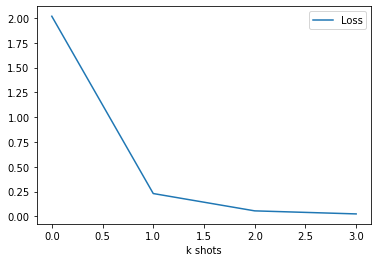

In [9]:
wave = SineWaveTask_multi(); 
k_shot_updates = 4
initialization_to_store_meta_losses()
for shots in range(k_shot_updates):
    new_model = training(model, wave, lr_k, shots)
    train_set_evaluation(new_model,wave,store_train_loss_meta) 

plt.plot(store_train_loss_meta,label = 'Loss')
plt.legend()
plt.xlabel('k shots')

<ipython-input-6-7e1e6714c74e>:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x)
<ipython-input-6-7e1e6714c74e>:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_true = torch.tensor(y_true)


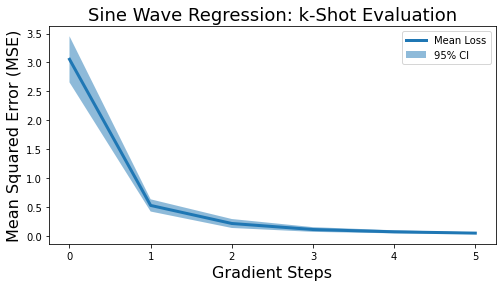

In [12]:
all_losses = []
num_eval = 1000
num_k_shots = 6

for test_eval in range(num_eval): 

    wave = SineWaveTask_multi(); 
    k_shot_updates = num_k_shots
    initialization_to_store_meta_losses()
    for shots in range(k_shot_updates):
        new_model = training(model, wave, lr_k, shots)
        train_set_evaluation(new_model,wave,store_train_loss_meta) 
        
    all_losses.append(np.array(store_train_loss_meta))

all_losses = np.array(all_losses)
np.save(f"reptile_multi_sine_{num_k_shots}.npy", all_losses)
    
fig, ax = plt.subplots(figsize=(8,4))

mean_loss = np.mean(all_losses, axis=0)

# confidence interval plotting help from: https://stackoverflow.com/questions/59747313/how-to-plot-confidence-interval-in-python
y = mean_loss
x = list(range(num_k_shots))
ci = 1.96 * np.std(all_losses, axis=0)**2/np.sqrt(len(y))

ax_size=16
title_size=18
                                                  
ax.plot(x, y, linewidth=3, label=f"Mean Loss")
ax.fill_between(x, (y-ci), (y+ci), alpha=.5,label=f"95% CI")
ax.set_xlabel("Gradient Steps",fontsize=ax_size)
ax.set_ylabel("Mean Squared Error (MSE)",fontsize=ax_size)
ax.set_title("Sine Wave Regression: k-Shot Evaluation",fontsize=title_size)
ax.legend()#loc="upper right")
plt.savefig("reptile_sine_wave_multidim_reg_kshot.png")

In [13]:
analysis_steps = [0, 1, num_k_shots-1]
for analysis_step in analysis_steps: 
    print(f"Step: {analysis_step}, Error: {mean_loss[analysis_step]}, Var: {ci[analysis_step]}")

Step: 0, Error: 3.0552478387355806, Var: 0.3992171627993859
Step: 1, Error: 0.5247177988365292, Var: 0.10564654234035513
Step: 5, Error: 0.04501637527067214, Var: 0.01355739429137957
